# 수업을 시작하기 전

딥러닝을 이해하기 위해, 기본적으로 CS231n 강의는 모두 들어야 합니다. RNN에 대한 강의는 10강을 참고하세요. 

[CS231n](http://cs231n.stanford.edu/)

![RNN 구조 그림](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdna%2FMYzgN%2FbtqA3fa5uyw%2FAAAAAAAAAAAAAAAAAAAAACP86IyZtfIMCKp7z5CBtiLA_XZyxO_X786tVSAWfq8U%2Fimg.png%3Fcredential%3DyqXZFxpELC7KVnFOS48ylbz2pIh7yKj8%26expires%3D1756652399%26allow_ip%3D%26allow_referer%3D%26signature%3D1oxykxG%252FRaTJvnkG4EWJmU6xuxo%253D)

## 0. 무엇을 배우나

크게 아래의 세 파트로 나누어 진행을 합니다. 
  - 첫째. 문자-단위 RNN으로 이름 분류하기
  - 둘째. 문자-단위 RNN으로 이름 생성하기
  - 셋째. Sequence to Sequence 네트워크와 Attention을 이용한 번역

**문자-단위 RNN으로 이름 분류하기**에서는 단어를 분류하기 위해 기초적인 문자-단위의 순환 신경망(RNN)을 구축하고 학습할 거예요. RNN을 사용하여 주어진 이름이 어떠한 언어인지를 분류합니다. 

**문자-단위 RNN으로 이름 생성하기**에서는 

## 1. 데이터 준비

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # EOS(end of sentence) 기호 추가

def findFiles(path): return glob.glob(path)

# 유니코드 문자열을 ASCII로 변환, https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# 파일을 읽고 줄 단위로 분리
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# 각 언어의 이름 목록인 category_lines 사전 생성
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Irish', 'Scottish', 'German', 'English', 'Polish', 'Arabic', 'Vietnamese', 'Japanese', 'Spanish', 'Chinese', 'Russian', 'Czech', 'Greek', 'French', 'Italian', 'Portuguese', 'Dutch', 'Korean']
O'Neal


## 2. 네트워크 
이 네트워크는 지난 튜토리얼의 RNN 이 다른 입력들과 연결되는 category tensor를 추가 인자로 가지게 확장합니다. category tensor는 문자 입력과 마찬가지로 one-hot 벡터입니다.

역자주: 기존 입력과 category tensor를 결합하여 입력으로 사용하기 때문에 입력의 사이즈가 n_categories 만큼 커집니다.

우리는 출력을 다음 문자의 확률로 해석합니다. 샘플링 할 때, 가장 확률이 높은 문자가 다음 입력 문자로 사용됩니다.

더 나은 동작을 위해 두 번째 선형 레이어 o2o (은닉과 출력을 결합한 후) 를 추가했습니다 . 또한 Drop-out 계층이 있습니다. 이 계층은 주어진 확률(여기서는 0.1)로 무작위로 입력을 0 # 으로 만듭니다. 일반적으로 입력을 흐리게 해서 과적합을 막는 데 사용됩니다. 여기서 우리는 고의로 일부 혼돈을 추가하고 샘플링 다양성을 높이기 위해 네트워크의 마지막에 이것을 사용합니다.

![RNN 구조 그림](https://i.imgur.com/jzVrf7f.png)

In [3]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

## 3. 학습

### 3.1. 학습 준비

제일 먼저 (category, line)의 무작위 쌍을 얻는 함수:

In [4]:
import random

# 목록에서 무작위 아이템 반환
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# 임의의 category 및 그 category에서 무작위 줄(이름) 얻기
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

각 시간 단계 마다 (즉, 학습 단어의 각 문자 마다) 네트워크의 입력은 (언어, 현재 문자, 은닉 상태) 가 되고, 출력은 (다음 문자, 다음 은닉 상태) 가 된다. 따라서 각 학습 세트 마다 언어, 입력 문자의 세트, 출력/목표 문자의 세트가 필요하다.

각 시간 단계마다 현재 문자에서 다음 문자를 예측하기 때문에, 문자 쌍은 한 줄(하나의 이름)에서 연속된 문자 그룹입니다. - 예를 들어 "ABCD<EOS>" 는 (《A》, 《B》), (《B》, 《C》), (《C》, 《D》), (《D》, 《EOS》) 로 생성합니다.

![RNN 세부 구조](https://i.imgur.com/JH58tXY.png)

In [10]:
# Category를 위한 One-hot 벡터
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# 입력을 위한 처음부터 마지막 문자(EOS 제외)까지의  One-hot 행렬
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# 목표를 위한 두번째 문자 부터 마지막(EOS)까지의 ``LongTensor``
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

Category(언어) Tensor는 <1 x n_categories> 크기의 One-hot Tensor 입니다. 학습시에 모든 시간 단계에서 네트워크에 이것을 전달합니다. - 이것은 설계 선택사항으로, 초기 은닉 상태 또는 또 다른 전략의 부분으로 포함될 수 있습니다.

In [5]:
# 임의의 Category에서 Category, Input, Target Tensor를 만듭니다.
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

### 3.2. 네트워크 학습

마지막 출력만 사용하는 분류와 달리, 모든 단계에서 예측을 수행하므로 모든 단계에서 손실을 계산합니다.

Autograd의 마법이 각 단계의 손실들을 간단하게 합하고 마지막에 역전파를 호출하게 해줍니다.

In [6]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = torch.Tensor([0]) # 또는 그냥 ``loss = 0`` 을 사용해도 됩니다.

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

학습에 걸리는 시간을 추적하기 위해 사람이 읽을 수 있는 문자열을 반환하는``timeSince (timestamp)`` 함수를 추가합니다:

In [7]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

학습은 일상적인 일입니다. - 몇 번 train() 을 호출하고, 몇 분 정도 기다렸다가 print_every 마다 현재 시간과 손실을 출력하고, 나중에 도식화를 위해 plot_every 마다 all_losses 에 평균 손실을 저장합니다.

In [11]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # ``plot_every`` 마다 초기화

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 18s (5000 5%) 3.1046
0m 33s (10000 10%) 2.2822
0m 48s (15000 15%) 2.3987
1m 3s (20000 20%) 2.8162
1m 19s (25000 25%) 2.7443
1m 34s (30000 30%) 3.4618
1m 49s (35000 35%) 1.9035
2m 4s (40000 40%) 2.8901
2m 19s (45000 45%) 2.5303
2m 35s (50000 50%) 2.9060
2m 50s (55000 55%) 2.9047
3m 5s (60000 60%) 2.4690
3m 20s (65000 65%) 2.3412
3m 35s (70000 70%) 2.1067
3m 50s (75000 75%) 1.3538
4m 5s (80000 80%) 1.6980
4m 20s (85000 85%) 3.2584
4m 36s (90000 90%) 2.4915
4m 51s (95000 95%) 2.5859
5m 7s (100000 100%) 2.0131


### 3.3. 손실 도식화

all_losses를 이용한 손실의 도식화는 네트워크의 학습 상태를 보여줍니다:

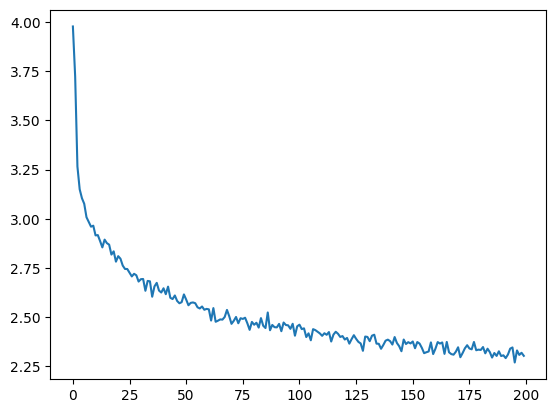

In [12]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

### 3.4. 네트워크 샘플링

샘플링을 위해서, 네트워크에 하나의 글자를 주고 다음 문자를 물어보고 이것을 다음 문자로 전달하는 것을 EOS 토큰까지 반복합니다.

  - 입력 카테고리(언어), 시작 문자, 비어 있는 은닉 상태를 위한 Tensor를 생성하십시오
  - 시작 문자로 output_name 문자열을 생성하십시오
  - 최대 출력 길이까지,
    - 현재 문자를 네트워크에 전달하십시오.
    - 가장 높은 출력에서 다음 문자와 다음 은닉 상태를 얻으십시오
    - 만일 문자가 EOS면, 여기서 멈추십시오
    - 만일 일반적인 문자라면, output_name 에 추가하고 계속하십시오
  - 마지막 이름을 반환하십시오

In [13]:
max_length = 20

# 카테고리와 시작 문자로부터 샘플링 하기
def sample(category, start_letter='A'):
    with torch.no_grad():  # 샘플링에서 히스토리를 추적할 필요 없음
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# 하나의 카테고리와 여러 시작 문자들로 여러 개의 샘플 얻기
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Rovekovev
Uantoukov
Shimovokov
Grenger
Erenger
Roumer
Santara
Pareza
Allan
Ching
Han
Iun


# 셋째. SEQUENCE TO SEQUENCE 네트워크와 ATTENTION을 이용한 번역

NLP 모델링 작업을 위한 데이터 전처리에 사용할 자체 클래스와 함수들을 작성해보겠습니다. 이 튜토리얼을 마친 뒤에는 torchtext 가 어떻게 지금까지의 튜토리얼들에서의 전처리 과정을 다루는지를 이후 튜토리얼들에서 배울 수 있습니다.

이 프로젝트에서는 신경망이 불어를 영어로 번역하도록 가르칠 예정입니다.

하나의 시퀀스를 다른 시퀀스로 바꾸는 두 개의 RNN이 함께 동작하는 sequence to sequence network 의 간단하지만 강력한 아이디어가 이것(번역)을 가능하게 합니다. 인코더 네트워크는 입력 시퀀스를 벡터로 압축하고, 디코더 네트워크는 해당 벡터를 새로운 시퀀스로 펼칩니다.

![seq2seq 그림](https://tutorials.pytorch.kr/_images/seq2seq.png)

이 모델을 개선하기 위해 Attention Mechanism 을 사용하면 디코더가 입력 시퀀스의 특정 범위에 집중할 수 있도록 합니다.

이전 튜토리얼에 있는 기초부터 시작하는 NLP: 문자-단위 RNN으로 이름 분류하기 와 기초부터 시작하는 NLP: 문자-단위 RNN으로 이름 생성하기 는 각각 인코더, 디코더 모델과 비슷한 컨센을 가지기 때문에 도움이 됩니다.

In [14]:
# 요구사항
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. 준비

문자 단위 RNN 튜토리얼에서 사용된 문자 인코딩과 유사하게, 언어의 각 단어들을 One-Hot 벡터 또는 그 단어의 주소에만 단 하나의 1을 제외하고 모두 0인 큰 벡터로 표현합니다. 한 가지 언어에 있는 수십 개의 문자와 달리 번역에는 아주 많은 단어들이 있기 때문에 인코딩 벡터는 매우 더 큽니다. 그러나 우리는 약간의 트릭를 써서 언어 당 수천 단어 만 사용하도록 데이터를 다듬을 것입니다.

![word encoding 그림](https://tutorials.pytorch.kr/_images/word-encoding.png)

나중에 네트워크의 입력 및 목표로 사용하려면 단어 당 고유 번호가 필요합니다. 이 모든 것을 추적하기 위해 우리는 단어→색인(word2index)과 색인→단어(index2word) 사전, 그리고 나중에 희귀 단어를 대체하는데 사용할 각 단어의 빈도 word2count 를 가진 Lang 이라는 헬퍼 클래스를 사용합니다.

In [15]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # SOS 와 EOS 포함

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

파일은 모두 유니 코드로 되어있어 간단하게 하기 위해 유니 코드 문자를 ASCII로 변환하고, 모든 문자를 소문자로 만들고, 대부분의 구두점을 지워줍니다.

In [16]:
# 유니 코드 문자열을 일반 ASCII로 변환하십시오.
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# 소문자, 다듬기, 그리고 문자가 아닌 문자 제거
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

데이터 파일을 읽기 위해, 먼저 파일을 줄 단위로 나눈 다음 각 줄을 쌍(pair)으로 나눕니다. 이 파일들은 모두 영어 → 다른 언어 형식이기 때문에, 만약 다른 언어 → 영어로 번역하고 싶다면, 쌍을 뒤집도록 reverse 플래그를 추가했습니다.

In [17]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # 파일을 읽고 줄로 분리
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # 모든 줄을 쌍으로 분리하고 정규화
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # 쌍을 뒤집고, Lang 인스턴스 생성
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

많은 예제 문장이 있고 신속하게 학습하기를 원하기 때문에 비교적 짧고 간단한 문장으로만 데이터 셋을 정리할 것입니다. 여기서 최대 길이는 10 단어 (종료 문장 부호 포함)이며 《I am》 또는 《He is》 등의 형태로 번역되는 문장으로 필터링됩니다.(이전에 아포스트로피는 대체 됨)

In [19]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

데이터 준비를 위한 전체 과정:

  - 텍스트 파일을 읽고 줄로 분리하고, 줄을 쌍으로 분리합니다.
  - 텍스트를 정규화 하고 길이와 내용으로 필터링 합니다.
  - 쌍을 이룬 문장들로 단어 리스트를 생성합니다.

In [20]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
['je ne suis pas celui qui devrait y aller', 'i m not the one who should go']


## 2. Seq2Seq 모델
Recurrent Neural Network(RNN)는 시퀀스에서 작동하고 다음 단계의 입력으로 자신의 출력을 사용하는 네트워크입니다.

Sequence to Sequence network, 또는 Seq2Seq 네트워크, 또는 Encoder Decoder network 는 인코더 및 디코더라고 하는 두 개의 RNN으로 구성된 모델입니다. 인코더는 입력 시퀀스를 읽고 단일 벡터를 출력하고, 디코더는 해당 벡터를 읽어 출력 시퀀스를 생성합니다.

![seq2seq 그림](https://tutorials.pytorch.kr/_images/seq2seq.png)

모든 입력에 해당하는 출력이 있는 단일 RNN의 시퀀스 예측과 달리 Seq2Seq 모델은 시퀀스 길이와 순서를 자유롭게하기 때문에 두 언어 사이의 번역에 이상적입니다.

다음 문장 Je ne suis pas le chat noir → I am not the black cat 를 살펴 봅시다. 입력 문장의 단어 대부분은 출력 문장에서 직역(chat noir 와 black cat)되지만 약간 다른 순서도 있습니다. ne/pas 구조로 인해 입력 문장에 단어가 하나 더 있습니다. 입력 단어의 시퀀스를 직역해서 정확한 번역을 만드는 것은 어려울 것입니다.

Seq2Seq 모델을 사용하면 인코더는 하나의 벡터를 생성합니다. 이상적인 경우에 입력 시퀀스의 《의미》를 문장의 N 차원 공간에 있는 단일 지점인 단일 벡터으로 인코딩합니다.

### 2.1. 인코더

Seq2Seq 네트워크의 인코더는 입력 문장의 모든 단어에 대해 어떤 값을 출력하는 RNN입니다. 모든 입력 단어에 대해 인코더는 벡터와 은닉 상태를 출력하고 다음 입력 단어를 위해 그 은닉 상태를 사용합니다.

![encoder network 그림](https://tutorials.pytorch.kr/_images/encoder-network.png)

In [21]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

### 2.2. 디코더

디코더는 인코더 출력 벡터를 받아서 번역을 생성하기 위한 단어 시퀀스를 출력합니다.

간단한 디코더

가장 간단한 Seq2Seq 디코더는 인코더의 마지막 출력만을 이용합니다. 이 마지막 출력은 전체 시퀀스에서 문맥을 인코드하기 때문에 문맥 벡터(context vector) 로 불립니다. 이 문맥 벡터는 디코더의 초기 은닉 상태로 사용 됩니다.

디코딩의 매 단계에서 디코더에게 입력 토큰과 은닉 상태가 주어집니다. 초기 입력 토큰은 문자열-시작 (start-of-string) <SOS> 토큰이고, 첫 은닉 상태는 문맥 벡터(인코더의 마지막 은닉 상태) 입니다.

![decoder network 그림](https://tutorials.pytorch.kr/_images/decoder-network.png)

In [22]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing 포함: 목표를 다음 입력으로 전달
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Teacher forcing 미포함: 자신의 예측을 다음 입력으로 사용
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # 입력으로 사용할 부분을 히스토리에서 분리

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None   # 학습 루프의 일관성 유지를 위해 `None` 을 추가로 반환

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

이 모델의 결과를 학습하고 관찰하는 것을 권장하지만, 공간을 절약하기 위해 최종 목적지로 바로 이동해서 Attention 메커니즘을 소개 할 것입니다.

### 2.3. Attention 디코더

문맥 벡터만 인코더와 디코더 사이로 전달 된다면, 단일 벡터가 전체 문장을 인코딩 해야하는 부담을 가지게 됩니다.

Attention은 디코더 네트워크가 자기 출력의 모든 단계에서 인코더 출력의 다른 부분에 《집중》 할 수 있게 합니다. 첫째 Attention 가중치 의 세트를 계산합니다. 이것은 가중치 조합을 만들기 위해서 인코더 출력 벡터와 곱해집니다. 그 결과(코드에서 attn_applied)는 입력 시퀀스의 특정 부분에 관한 정보를 포함해야하고 따라서 디코더가 알맞은 출력 단어를 선택하는 것을 도와줍니다.

![Imgur 스크린샷](https://i.imgur.com/1152PYf.png)

어텐션 가중치 계산은 디코더의 입력 및 은닉 상태를 입력으로 사용하는 다른 feed-forwad 계층인 attn 으로 수행됩니다. 학습 데이터에는 모든 크기의 문장이 있기 때문에 이 계층을 실제로 만들고 학습시키려면 적용 할 수 있는 최대 문장 길이 (인코더 출력을 위한 입력 길이)를 선택해야 합니다. 최대 길이의 문장은 모든 Attention 가중치를 사용하지만 더 짧은 문장은 처음 몇 개만 사용합니다.

![attention decoder network 그림](https://tutorials.pytorch.kr/_images/attention-decoder-network.png)

부가적 어텐션(Additive Attention)이라고도 알려진 바다나우 어텐션(Bahdanau Attention)은 기계 번역 작업과 같은 시퀀스-투-시퀀스 모델에서 일반적으로 사용하는 어텐션 기법(mechanism)입니다. 이 어텐션 기법은 Bahdanau et al.의 논문인 Neural Machine Translation by Jointly Learning to Align and Translate 에서 소개되었습니다. 이 어텐션 기법은 학습된 정렬 모델(learned alignment model)을 사용하여 인코더와 디코더의 은닉 상태(hidden state) 간의 어텐션 점수를 계산합니다. 이는 정렬된 어텐션 점수를 계산하기 위해 feed-forward 신경망을 사용합니다.

또는, 디코더의 은닉 상태와 인코더의 은닉 상태 사이의 어텐션 점수를 Dot-Product로 계산하는 루옹 어텐션(Luong Attention)과 같은 다른 어텐션 기법들을 사용할 수도 있습니다. 이는 바다나우 어텐션(Bahdanau Attention)에서 사용하는 비선형 변환(non-linear transformation)을 사용하지는 않습니다.

이 튜토리얼에서는 바다나우 어텐션(Bahdanau Attention)을 사용할 것입니다. 하지만 이를 루옹 어텐션(Luong Attention) 기법으로 변경해보는 것도 좋은 연습이 될 것입니다.

In [23]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing 포함: 목표를 다음 입력으로 전달
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Teacher forcing 미포함: 자신의 예측을 다음 입력으로 사용
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # 입력으로 사용할 부분을 히스토리에서 분리

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

## 3. 학습

### 3.1. 학습 데이터 준비

학습을 위해서, 각 쌍마다 입력 Tensor(입력 문장의 단어 주소)와 목표 Tensor(목표 문장의 단어 주소)가 필요합니다. 이 벡터들을 생성하는 동안 두 시퀀스에 EOS 토큰을 추가 합니다.

In [24]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

### 3.2. 모델 학습

학습을 위해서 인코더에 입력 문장을 넣고 모든 출력과 최신 은닉 상태를 추적합니다. 그런 다음 디코더에 첫 번째 입력으로 <SOS> 토큰과 인코더의 마지막 은닉 상태가 첫 번째 은닉 상태로 제공됩니다.

《Teacher forcing》은 다음 입력으로 디코더의 예측을 사용하는 대신 실제 목표 출력을 다음 입력으로 사용하는 컨셉입니다. 《Teacher forcing》을 사용하면 수렴이 빨리되지만 학습된 네트워크가 잘못 사용될 때 불안정성을 보입니다..

Teacher-forced 네트워크의 출력이 일관된 문법으로 읽지만 정확한 번역과는 거리가 멀다는 것을 볼 수 있습니다. 직관적으로 출력 문법을 표현하는 법을 배우고 교사가 처음 몇 단어를 말하면 의미를 《선택》 할 수 있지만, 번역에서 처음으로 문장을 만드는 법은 잘 배우지 못합니다.

PyTorch의 autograd 가 제공하는 자유 덕분에 간단한 If 문으로 Teacher Forcing을 사용할지 아니면 사용하지 않을지를 선택할 수 있습니다. 더 많이 사용하려면 teacher_forcing_ratio 를 확인하십시오.

In [25]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

이것은 현재 시간과 진행률%을 고려해 경과된 시간과 남은 예상 시간을 출력하는 헬퍼 함수입니다.

In [26]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

전체 학습 과정은 다음과 같습니다:

  - 타이머 시작
  - optimizers와 criterion 초기화
  - 학습 쌍의 세트 생성
  - 도식화를 위한 빈 손실 배열 시작
그런 다음 우리는 여러 번 train 을 호출하며 때로는 진행률 (예제의 %, 현재까지의 예상 시간)과 평균 손실을 출력합니다.

In [27]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

### 3.3. 결과 도식화

matplotlib로 학습 중에 저장된 손실 값 plot_losses 의 배열을 사용하여 도식화합니다.

In [28]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # 주기적인 간격으로 이 locator가 tick을 설정
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

### 3.4. 평가

평가는 대부분 학습과 동일하지만 목표가 없으므로 각 단계마다 디코더의 예측을 되돌려 전달합니다. 단어를 예측할 때마다 그 단어를 출력 문자열에 추가합니다. 만약 EOS 토큰을 예측하면 거기에서 멈춥니다. 나중에 도식화를 위해서 디코더의 Attention 출력을 저장합니다.

In [29]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

학습 세트에 있는 임의의 문장으로 평가한 다음, 입력(input), 목표(target) 및 출력(output) 값들을 표시하여 주관적으로 품질에 대해 판단해볼 수 있습니다:

In [30]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

### 3.5. 학습과 평가

이러한 모든 헬퍼 함수를 이용해서 (추가 작업처럼 보이지만 여러 실험을 더 쉽게 수행 할 수 있음) 실제로 네트워크를 초기화하고 학습을 시작할 수 있습니다.

입력 문장이 많이 필터링되었음을 기억하십시오. 이 작은 데이터 세트의 경우 256 크기의 은닉 노드(hidden node)와 단일 GRU 계층 같은 상대적으로 작은 네트워크를 사용할 수 있습니다. MacBook CPU에서 약 40분 후에 합리적인 결과를 얻을 것입니다.

In [ ]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
1m 9s (- 17m 28s) (5 6%) 1.5437
2m 20s (- 16m 25s) (10 12%) 0.6817


드롭아웃(dropout) 레이어들을 평가 (eval) 모드로 설정합니다.

In [ ]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

### 3.6. Attention 시각화

Attention 메커니즘의 유용한 속성은 하나는 해석 가능성이 높은 출력입니다. 입력 시퀀스의 특정 인코더 출력에 가중치를 부여하는 데 사용되므로 각 시간 단계에서 네트워크가 가장 집중되는 위치를 파악할 수 있습니다.

Attention 출력을 행렬로 표시하기 위해서는 plt.matshow(attentions) 을 그냥 실행해도 됩니다. 하지만 좀 더 나은 시각화를 위해 축(axis)과 라벨(label)을 추가하는 약간의 작업을 더 해보겠습니다:

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # 축 설정
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # 매 틱마다 라벨 보여주기
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])


evaluateAndShowAttention('il n est pas aussi grand que son pere')

evaluateAndShowAttention('je suis trop fatigue pour conduire')

evaluateAndShowAttention('je suis desole si c est une question idiote')

evaluateAndShowAttention('je suis reellement fiere de vous')